## Libraries

In [2]:
import pandas as pd
import numpy as np

## Load the data

In [3]:
train = pd.read_pickle('../features/train.pkl')

In [4]:
test = pd.read_pickle('../features/test.pkl')

## Feature selection

In [11]:
features = ['cosin_sim', 'word_share', 'q1_char_num', 'q1_word_num', 'q2_char_num', 'q2_word_num',
            'start_with_same_world', 'rfidf_share', 'char_difference', 'word_difference',
           'seq_simhash_distance', 'shingle_simhash_distance', 'avg_word_len_q1', 'avg_word_len_q2',
           'avg_word_difference', 'unigrams_common_count', 'bigrams_common_count', 'unigrams_common_ratio',
           'bigrams_common_ratio', 'word2vec_q1_mean', 'word2vec_q2_mean']

target = 'is_duplicate'

X, y = train[features], train[target]

## Oversampling

In [34]:
pos_train = X[y == 1]
neg_train = X[y == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

X = pd.concat([pos_train, neg_train])
y = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()

del pos_train, neg_train

0.19124366100096607


## Feature importance

In [36]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

In [37]:
model = XGBClassifier(n_estimators=700, learning_rate=0.1, max_depth=6, subsample=0.5,
                      gamma=1.5, seed=42, colsample_bytree=0.7)
model.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=1.5, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=700, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.5)

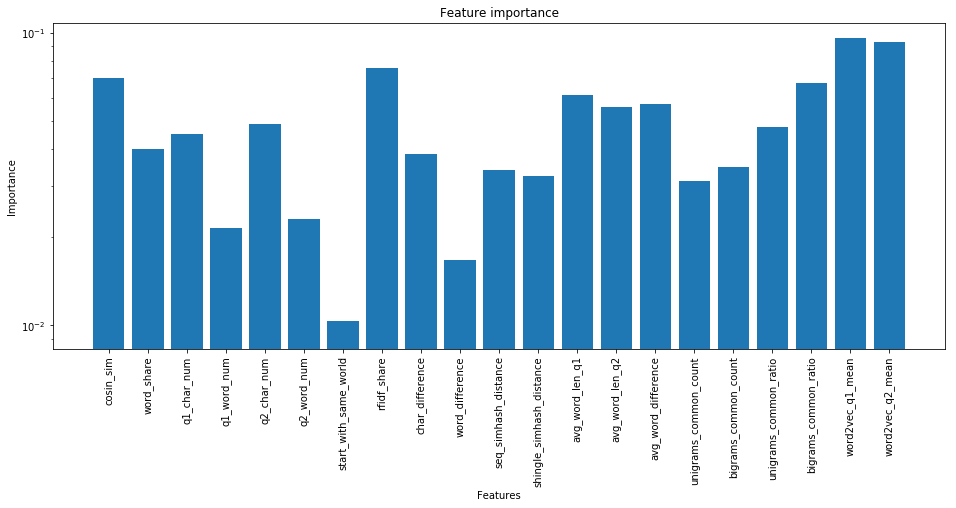

In [38]:
feature_importance = model.feature_importances_

plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')

plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), features, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [39]:
pd.DataFrame(model.feature_importances_, columns=['weights'], index=features)

,weights
cosin_sim,0.069787
word_share,0.039899
q1_char_num,0.045110
q1_word_num,0.021516
q2_char_num,0.048711
q2_word_num,0.023038
start_with_same_world,0.010363
rfidf_share,0.075964
char_difference,0.038641
word_difference,0.016715
